## 1.2. Library Setup 

In [3]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Keras library 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

# Different CNN Model
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121

# To chain two different data augmented images for training
from itertools import chain

#  Distributed Computing
import tensorflow as tf


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## 1.3 Parameter Setup for Model Training

In [4]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

# 2. Image Augmentation

In [5]:
# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )
print('Data Augmentation 2 was created')

data_generator_3 = ImageDataGenerator (rescale=1./255)

Data Augmentation 1 was created
Data Augmentation 2 was created


In [6]:
train_generator1 = data_generator_1.flow_from_directory(
    directory = "/kaggle/input/labeled-chest-xray-images/chest_xray/train", # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

print('Data Augmentation 1 was used to generate train data set\n')


test_generator = data_generator_3.flow_from_directory(
    directory = "/kaggle/input/labeled-chest-xray-images/chest_xray/test", # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)


Found 5232 images belonging to 2 classes.
Data Augmentation 1 was used to generate train data set

Found 624 images belonging to 2 classes.


# 3. EDA

In [7]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


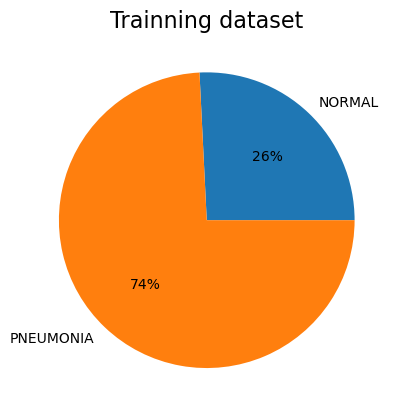

In [8]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [9]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator1.classes))
print("Number of normal images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in train_generator1.classes if label == 1]))
print()

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of normal images:", len([label for label in test_generator.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in test_generator.classes if label == 1]))
print()


Dataset Characteristics of Train Data Set:
Number of images: 5232
Number of normal images: 1349
Number of pneumonia images: 3883

Dataset Characteristics of Test Data Set:
Number of images: 624
Number of normal images: 234
Number of pneumonia images: 390



In [10]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 1.939214232765011, 1: 0.6737058975019315}

## 3.3 Image Samples

Train image data from Data Augmentation 1


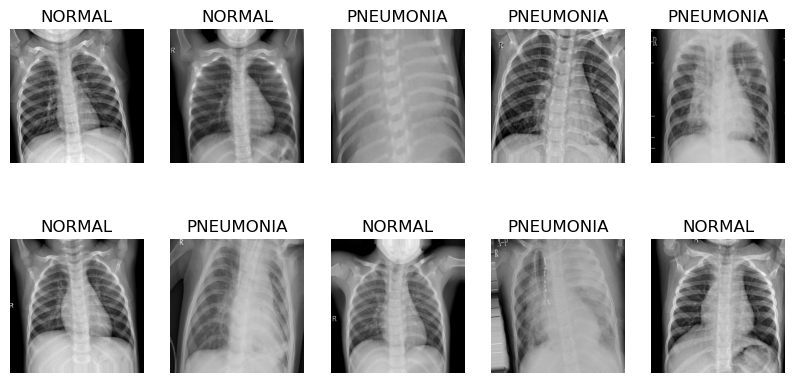

In [11]:
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[10, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()


# 4. Convolutional neural networks (CNNs)


In [12]:
# Define the epochs for training 
EPOCHS = 2
num_gpus = 2
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)
train_data = train_generator1

# 4. DenseNet

In [13]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

# Open a strategy scope
with strategy.scope():
    base_model_DenseNet = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_DenseNet.layers:
        layer.trainable = False  
    
    # Create a new model and add the DenseNet121 base model
    model_DenseNet = Sequential()
    model_DenseNet.add(base_model_DenseNet)

    # Add a global average pooling layer and output layer for classification
    model_DenseNet.add(GlobalAveragePooling2D())
    model_DenseNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_DenseNet.add(Dropout(0.4))
    model_DenseNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_DenseNet.add(Dropout(0.2))    
    model_DenseNet.add(Dense(2, activation='softmax'))

    # Model summary
    print("Model Summary (DenseNet121):")
    model_DenseNet.summary()
    print()

    # Compile the model
    model_DenseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_DenseNet = model_DenseNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_DenseNet, val_accuracy_DenseNet = model_DenseNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_DenseNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_DenseNet:.4f}')

29084464/29084464 [==============================] - 0s 0us/step
Model Summary (DenseNet121):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 9, 9, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)        

In [14]:
data = {
    'DenseNet': val_accuracy_DenseNet
}


In [15]:
df = pd.DataFrame.from_dict(data, orient='index', columns=['accuracy'])
df = df.reset_index().rename(columns={'index': 'model'})

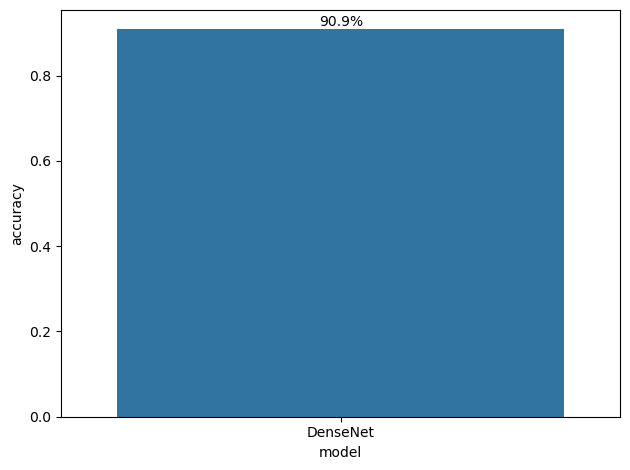

In [16]:
# Create bar chart
sns.barplot(x='model', y='accuracy', data=df)

# Add labels to bars
ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=10)

# Adjust the layout
plt.tight_layout()

plt.show()

# 6. Prediction Result Samples

2/2 [==============================] - 11s 3s/step


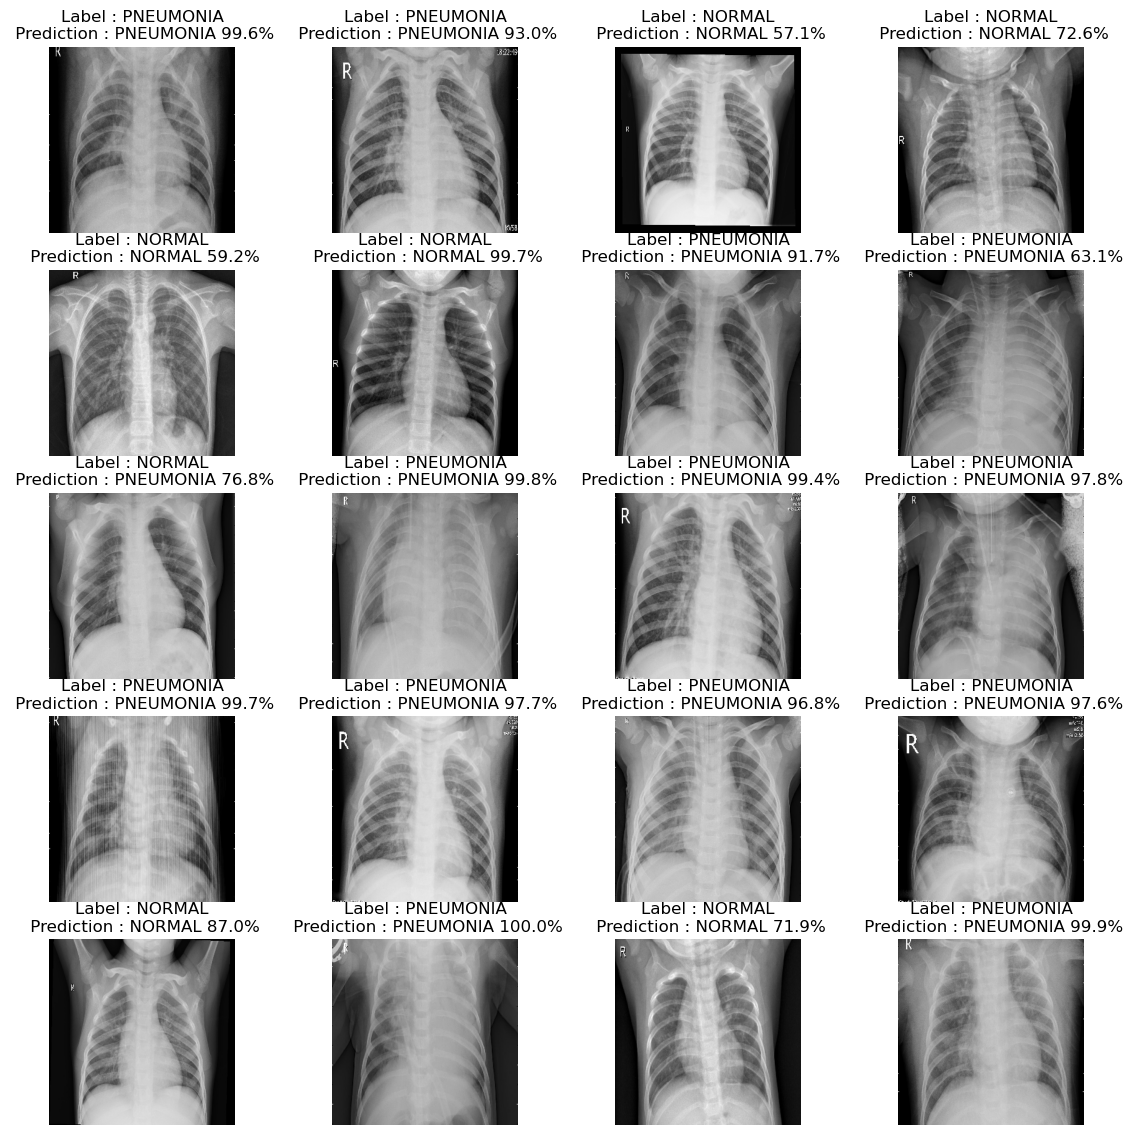

In [17]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_DenseNet.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()